<div style="text-align: right"> Raafay Uqaily </div>

<left>FINM 33150 - Quantitative Trading Strategies</left> 
<br>
<left>Winter 2024</left>

<h2><center> Homework 1: Futures Spreads Dynamics </center></h2>

### Import Statements

In [82]:
import os
import quandl
import datetime

import matplotlib.pyplot as plt
import statsmodels.api as sm
import plotnine as p9
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sp

### API Key

In [83]:
api_key = 'Enter API Key'

### Data Retrevial Helper Functions

In [84]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key='6SrNeGHs_yp2pmDei8FV', **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

## 1. Data Extraction

### Implied Volatility Model (IVM) Data Table

<span style="color: rgb(0, 0, 128);">The code below uses the fetch_quandl_table function to pull data.</span>

In [85]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Data file /Users/raafayuqaily/quandl_data_table_downloads/AR/IVM_20240122.zip size 290715410 exists already, no need to download


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,V2024,2023-07-27,58.040000,0.303074,-0.004934,NaN,-0.005185,...,-0.013514,-0.210955,0.274140,1.697856,-1.023394,-4.179139,-0.549587,0.444217,421.24,445.0
1,ICE,KC,KC,H2026,2023-10-02,158.550000,0.288991,0.015911,NaN,0.000022,...,0.025836,-0.177754,0.101765,1.435220,-0.445698,-2.374568,-0.684043,0.532352,863.15,899.0
2,NYM,NG,NG,F2029,2023-07-27,4.703000,0.334631,NaN,NaN,NaN,...,0.159299,0.133878,-1.147995,-1.006677,1.590494,1.477700,-0.737270,0.754384,1979.00,1980.0
3,NYX,C,C,U2025,2023-10-02,2666.000000,0.231555,NaN,NaN,NaN,...,0.120610,-2.579713,1.159924,594.907525,-91.601577,-52350.067091,-0.074339,0.075473,696.80,714.0
4,CBT,BO,BO,1M,2023-07-27,67.346897,0.352890,-0.002929,-0.005976,0.002417,...,-0.024721,0.420288,-0.644045,23.556375,14.352899,-214.004951,-0.222364,0.238453,31.00,31.0


<span style="color: rgb(0, 0, 128);"> The code below converts dates into more useful objects instead of strings. </span>

In [86]:
pd.to_datetime(t_ivm.date, format='%Y-%m-%d')

0         2023-07-27
1         2023-10-02
2         2023-07-27
3         2023-10-02
4         2023-07-27
             ...    
4910738   2020-08-31
4910739   2023-07-20
4910740   2023-07-21
4910741   2023-07-25
4910742   2023-07-26
Name: date, Length: 4910743, dtype: datetime64[ns]

<span style="color: rgb(0, 0, 128);"> The code below filters the data to be between 3rd December 2020 through 31st August 2023. It also only includes futures with quarterly expiration dates (H, M, U, Z). </span>

In [87]:
start_date = '2020-12-03'
end_date = '2023-08-31'

filtered_t_ivm = t_ivm[(t_ivm['date'] >= start_date) & (t_ivm['date'] <= end_date)]

quarterly_codes = ['H', 'M', 'U', 'Z']

filtered_t_ivm = filtered_t_ivm[filtered_t_ivm['expiration'].str.startswith(tuple(quarterly_codes))]
filtered_t_ivm

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
12,CBT,BO,BO,H2024,2023-07-27,61.2500,0.305667,0.010000,0.014024,0.002290,...,0.035488,0.044920,-0.375185,1.377109,1.017570,-4.142132,-0.464306,0.449384,211.24,231.0
16,CBT,BO,BO,U2023,2023-07-27,65.8200,0.353609,-0.003242,-0.006429,0.002404,...,-0.027875,0.440011,-0.608474,26.505782,15.366993,-253.462412,-0.216632,0.231917,29.24,49.0
17,CBT,BO,BO,U2024,2023-07-27,58.8900,0.301232,-0.003508,0.003068,-0.004221,...,-0.009456,-0.180687,0.222978,1.519551,-0.867324,-3.879493,-0.534712,0.440668,393.24,414.0
19,CBT,BO,BO,Z2023,2023-07-27,62.0700,0.318144,0.006360,0.007739,0.002287,...,0.028071,0.105257,-0.564205,2.506645,2.372051,-8.564727,-0.378759,0.441280,120.24,140.0
20,CBT,BO,BO,Z2024,2023-07-27,57.6200,0.263394,0.089451,NaN,0.043118,...,0.094901,0.629907,0.055164,-1.424784,0.064194,1.730546,-0.636143,0.462469,484.24,505.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4649570,NYM,RB,RB,Z2023,2023-07-26,2.3745,0.320597,0.031089,0.023982,0.022138,...,0.077962,1.438394,-0.363441,-16.649809,-0.420678,56.701393,-0.364012,0.429940,124.00,127.0
4910739,NYX,W,W,Z2025,2023-07-20,532.9000,0.173046,NaN,NaN,NaN,...,0.011437,-1.383735,-5.518864,58.390517,453.296306,841.926458,-0.238079,0.101789,837.00,848.0
4910740,NYX,W,W,Z2025,2023-07-21,536.7000,0.172972,NaN,NaN,NaN,...,0.009765,-1.430908,-5.390566,67.939188,517.229694,963.982513,-0.245185,0.094683,836.00,847.0
4910741,NYX,W,W,Z2025,2023-07-25,535.6000,0.172896,NaN,NaN,NaN,...,0.008361,-1.395793,-5.122230,64.156168,482.150983,890.888072,-0.243133,0.096735,832.00,843.0


## 1.1 Futures Pair W vs. X

### ICE_T_T (W) Data Table

<span style="color: rgb(0, 0, 128);"> The code below further filters data to only include second month quarterly futures prices for the following ticker: 'ICE_T_T'. </span>

In [88]:
t_ice_t_t = filtered_t_ivm.loc[t_ivm.exchange_code=='ICE']
t_ice_t_t = t_ice_t_t.loc[t_ice_t_t.futures_code=='T']
t_ice_t_t = t_ice_t_t.loc[t_ice_t_t.option_code=='T']

# Filter rows with termination_time above 30
t_ice_t_t = t_ice_t_t[t_ice_t_t['days_termination'] > 30]

# Sort by date and termination_time
t_ice_t_t = t_ice_t_t.sort_values(by=['date', 'days_termination'])

# Keep the first row for each unique date
t_ice_t_t = t_ice_t_t.drop_duplicates(subset='date', keep='first')

t_ice_t_t

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
3728801,ICE,T,T,H2021,2020-12-03,45.91,0.362277,-0.082346,-0.151121,0.009378,...,-0.407757,0.778180,2.862218,2.283795,-8.925477,-12.513680,-0.530846,0.392825,75.85,78.0
3728802,ICE,T,T,H2021,2020-12-04,46.54,0.351268,-0.077228,-0.141982,0.009759,...,-0.396028,0.865805,3.002390,2.081729,-10.024275,-13.555620,-0.508108,0.393794,74.85,77.0
3728803,ICE,T,T,H2021,2020-12-07,46.09,0.357136,-0.088783,-0.158692,0.008799,...,-0.460052,0.732777,3.908887,4.480739,-14.934799,-24.871612,-0.516410,0.359059,71.85,74.0
3728804,ICE,T,T,H2021,2020-12-08,45.96,0.354829,-0.091064,-0.164856,0.008859,...,-0.475409,0.740879,3.976338,4.511903,-14.894921,-24.050652,-0.531935,0.346616,70.85,73.0
3728805,ICE,T,T,H2021,2020-12-09,45.87,0.351812,-0.092696,-0.173841,0.010255,...,-0.485856,0.884303,3.901652,3.598483,-14.125245,-21.112787,-0.548667,0.348576,69.85,72.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66107,ICE,T,T,Z2023,2023-08-25,79.09,0.282881,-0.050559,-0.091901,0.004143,...,-0.306114,0.514860,2.927820,5.698810,-15.261240,-39.123640,-0.381602,0.283374,83.85,82.0
458978,ICE,T,T,Z2023,2023-08-28,79.21,0.286922,-0.052519,-0.095249,0.004294,...,-0.319278,0.529635,3.135389,5.972300,-16.563195,-40.065424,-0.392421,0.281858,80.85,79.0
461377,ICE,T,T,Z2023,2023-08-29,80.17,0.279802,-0.051235,-0.092790,0.004344,...,-0.320782,0.560832,3.367107,6.535965,-18.462843,-46.082385,-0.376816,0.269811,79.85,78.0
463072,ICE,T,T,Z2023,2023-08-30,80.57,0.276195,-0.047510,-0.085684,0.003928,...,-0.303492,0.524567,3.305769,7.896770,-18.485060,-55.308745,-0.363775,0.264834,78.85,77.0


### ICE_G_G (X) Data Table

<span style="color: rgb(0, 0, 128);"> The code below further filters data to only include second month quarterly futures prices for the following ticker: 'ICE_G_G'. </span>

In [89]:
t_ice_g_g = filtered_t_ivm.loc[t_ivm.exchange_code=='ICE']
t_ice_g_g = t_ice_g_g.loc[t_ice_g_g.futures_code=='G']
t_ice_g_g = t_ice_g_g.loc[t_ice_g_g.option_code=='G']

# Filter rows with termination_time above 30
t_ice_g_g = t_ice_g_g[t_ice_g_g['days_termination'] > 30]

# Sort by date and termination_time
t_ice_g_g = t_ice_g_g.sort_values(by=['date', 'days_termination'])

# Keep the first row for each unique date
t_ice_g_g = t_ice_g_g.drop_duplicates(subset='date', keep='first')

t_ice_g_g

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
3229069,ICE,G,G,H2021,2020-12-03,404.75,0.377799,-0.046897,-0.093657,0.003742,...,-0.197272,0.368820,0.288525,-1.045831,-0.758664,1.264430,-0.442588,0.351100,90.85,98.0
3229070,ICE,G,G,H2021,2020-12-04,406.00,0.379012,-0.047249,-0.094644,0.003823,...,-0.198592,0.379745,0.254675,-1.311176,-0.478532,2.795570,-0.445672,0.348017,89.85,97.0
3229071,ICE,G,G,H2021,2020-12-07,410.00,0.382357,-0.047298,-0.094844,0.003644,...,-0.200069,0.369966,0.248299,-1.088128,-0.426899,2.156216,-0.436427,0.346871,86.85,94.0
3229072,ICE,G,G,H2021,2020-12-08,409.75,0.375657,-0.047403,-0.095445,0.003729,...,-0.204182,0.389794,0.231478,-1.422499,-0.341754,3.332610,-0.435817,0.338823,85.85,93.0
3229073,ICE,G,G,H2021,2020-12-09,406.75,0.374841,-0.069072,-0.126562,0.002159,...,-0.307065,0.240010,1.129727,0.776946,-4.006904,-6.426638,-0.447517,0.319738,84.85,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65894,ICE,G,G,Z2023,2023-08-25,855.00,0.343146,0.013699,0.033533,0.006733,...,0.038945,0.346205,-0.019454,0.685156,0.304680,-3.004173,-0.379490,0.510826,108.85,102.0
458765,ICE,G,G,Z2023,2023-08-28,855.25,0.345362,0.013826,0.033440,0.006868,...,0.039791,0.360686,-0.041699,0.667262,0.455760,-3.164362,-0.379782,0.510533,105.85,99.0
461164,ICE,G,G,Z2023,2023-08-29,844.50,0.355246,0.011352,0.024308,0.005807,...,0.033755,0.295492,-0.185271,0.832195,1.063103,-3.736104,-0.384375,0.487464,104.85,98.0
462859,ICE,G,G,Z2023,2023-08-30,827.50,0.340506,0.006389,0.015485,0.002870,...,0.020130,0.139128,-0.055697,1.909416,0.575939,-7.535250,-0.355381,0.432292,103.85,97.0


### Futures Pair W vs. X Spread Data Table

<span style="color: rgb(0, 0, 128);"> The code below combines prices for both futures (W and X) and calculates the spread (after incorporating the multiplier for X). Values in the dataframe produced were matched with examples of St provided in the pdf. </span>

In [91]:
w_spread = t_ice_t_t[['date', 'futures']]
w_spread = w_spread.rename(columns={'futures':'ICE_T_T price'})

x_spread = t_ice_g_g[['date', 'futures']]
x_spread = x_spread.rename(columns={'futures':'ICE_G_G price'})
x_spread['ICE_G_G price'] = x_spread['ICE_G_G price']*0.11

w_vs_x_spread = pd.merge(w_spread, x_spread, on='date', how='inner')
w_vs_x_spread['spread'] = w_vs_x_spread['ICE_G_G price'] - w_vs_x_spread['ICE_T_T price']
w_vs_x_spread.set_index('date')
w_vs_x_spread.reset_index()
w_vs_x_spread

,date,ICE_T_T price,ICE_G_G price,spread
0,2020-12-03,45.91,44.5225,-1.3875
1,2020-12-04,46.54,44.6600,-1.8800
2,2020-12-07,46.09,45.1000,-0.9900
3,2020-12-08,45.96,45.0725,-0.8875
4,2020-12-09,45.87,44.7425,-1.1275
...,...,...,...,...
704,2023-08-25,79.09,94.0500,14.9600
705,2023-08-28,79.21,94.0775,14.8675
706,2023-08-29,80.17,92.8950,12.7250
707,2023-08-30,80.57,91.0250,10.4550


## 1.2 Futures Pair Y vs. Z

### NYM_RB_RB (Y) Data Table

<span style="color: rgb(0, 0, 128);"> The code below further filters data to only include second month quarterly futures prices for the following ticker: 'NYM_RB_RB'. </span>

In [92]:
t_nym_rb_rb = filtered_t_ivm.loc[t_ivm.exchange_code=='NYM']
t_nym_rb_rb = t_nym_rb_rb.loc[t_nym_rb_rb.futures_code=='RB']
t_nym_rb_rb = t_nym_rb_rb.loc[t_nym_rb_rb.option_code=='RB']

# Filter rows with termination_time above 30
t_nym_rb_rb = t_nym_rb_rb[t_nym_rb_rb['days_termination'] > 30]

# Sort by date and termination_time
t_nym_rb_rb = t_nym_rb_rb.sort_values(by=['date', 'days_termination'])

# Keep the first row for each unique date
t_nym_rb_rb = t_nym_rb_rb.drop_duplicates(subset='date', keep='first')

t_nym_rb_rb

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
4592065,NYM,RB,RB,H2021,2020-12-03,1.2867,0.404940,-0.044632,-0.066643,0.020366,...,-0.221127,1.574470,1.714716,-19.976051,-4.980849,73.815119,-0.402904,0.389773,82.0,85.0
4592066,NYM,RB,RB,H2021,2020-12-04,1.2951,0.393243,-0.054731,-0.081039,0.024473,...,-0.269195,1.937343,2.017534,-24.032997,-5.241950,87.494058,-0.409411,0.383266,81.0,84.0
4592067,NYM,RB,RB,H2021,2020-12-07,1.2850,0.401325,-0.060988,-0.080354,0.013237,...,-0.296558,1.136817,2.781911,-14.084529,-9.812550,52.360167,-0.390021,0.369818,78.0,81.0
4592068,NYM,RB,RB,H2021,2020-12-08,1.2851,0.392393,-0.044372,-0.068010,0.010609,...,-0.215338,1.003057,1.490991,-13.924953,-3.699306,57.763046,-0.378670,0.353479,77.0,80.0
4592069,NYM,RB,RB,H2021,2020-12-09,1.2983,0.397532,-0.028744,-0.054577,0.002399,...,-0.123218,0.301424,-0.066674,-2.823388,3.541613,8.807728,-0.366416,0.348710,76.0,79.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66363,NYM,RB,RB,Z2023,2023-08-25,2.4221,0.363923,0.014015,0.012494,0.017915,...,0.014616,1.274807,0.373645,-15.152559,-3.183673,54.594996,-0.359906,0.410092,94.0,97.0
459232,NYM,RB,RB,Z2023,2023-08-28,2.3787,0.351590,0.016047,0.012811,0.027980,...,-0.007817,2.140276,1.253695,-29.298817,-9.398237,118.371210,-0.359737,0.400393,91.0,94.0
461631,NYM,RB,RB,Z2023,2023-08-29,2.3810,0.358705,0.028670,0.023485,0.025822,...,0.058538,1.857082,0.144319,-23.682954,-3.704708,89.387931,-0.354697,0.413413,90.0,93.0
463327,NYM,RB,RB,Z2023,2023-08-30,2.3915,0.365171,0.034519,0.026591,0.026549,...,0.084224,1.826237,-0.336170,-21.927950,-1.151437,77.784964,-0.359097,0.422806,89.0,92.0


### ICE_G_G (Z) Data Table

<span style="color: rgb(0, 0, 128);"> Since Z is the same as X in my case, I am simply calling the dataframe that includes data for the following ticker: 'ICE_G_G'. </span>

In [93]:
t_ice_g_g

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
3229069,ICE,G,G,H2021,2020-12-03,404.75,0.377799,-0.046897,-0.093657,0.003742,...,-0.197272,0.368820,0.288525,-1.045831,-0.758664,1.264430,-0.442588,0.351100,90.85,98.0
3229070,ICE,G,G,H2021,2020-12-04,406.00,0.379012,-0.047249,-0.094644,0.003823,...,-0.198592,0.379745,0.254675,-1.311176,-0.478532,2.795570,-0.445672,0.348017,89.85,97.0
3229071,ICE,G,G,H2021,2020-12-07,410.00,0.382357,-0.047298,-0.094844,0.003644,...,-0.200069,0.369966,0.248299,-1.088128,-0.426899,2.156216,-0.436427,0.346871,86.85,94.0
3229072,ICE,G,G,H2021,2020-12-08,409.75,0.375657,-0.047403,-0.095445,0.003729,...,-0.204182,0.389794,0.231478,-1.422499,-0.341754,3.332610,-0.435817,0.338823,85.85,93.0
3229073,ICE,G,G,H2021,2020-12-09,406.75,0.374841,-0.069072,-0.126562,0.002159,...,-0.307065,0.240010,1.129727,0.776946,-4.006904,-6.426638,-0.447517,0.319738,84.85,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65894,ICE,G,G,Z2023,2023-08-25,855.00,0.343146,0.013699,0.033533,0.006733,...,0.038945,0.346205,-0.019454,0.685156,0.304680,-3.004173,-0.379490,0.510826,108.85,102.0
458765,ICE,G,G,Z2023,2023-08-28,855.25,0.345362,0.013826,0.033440,0.006868,...,0.039791,0.360686,-0.041699,0.667262,0.455760,-3.164362,-0.379782,0.510533,105.85,99.0
461164,ICE,G,G,Z2023,2023-08-29,844.50,0.355246,0.011352,0.024308,0.005807,...,0.033755,0.295492,-0.185271,0.832195,1.063103,-3.736104,-0.384375,0.487464,104.85,98.0
462859,ICE,G,G,Z2023,2023-08-30,827.50,0.340506,0.006389,0.015485,0.002870,...,0.020130,0.139128,-0.055697,1.909416,0.575939,-7.535250,-0.355381,0.432292,103.85,97.0


### Futures Pair Y vs. Z Spread Data Table

<span style="color: rgb(0, 0, 128);"> The code below combines prices for both futures (Y and Z) and calculates the spread (after incorporating the multiplier for Z). Values in the dataframe produced were matched with examples of St provided in the pdf. </span>

In [94]:
y_spread = t_nym_rb_rb[['date', 'futures']]
y_spread = y_spread.rename(columns={'futures':'NYM_RB_RB price'})

z_spread = t_ice_g_g[['date', 'futures']]
z_spread = z_spread.rename(columns={'futures':'ICE_G_G price'})
z_spread['ICE_G_G price'] = z_spread['ICE_G_G price']*0.0033

y_vs_z_spread = pd.merge(y_spread, z_spread, on='date', how='inner')
y_vs_z_spread['spread'] = y_vs_z_spread['ICE_G_G price'] - y_vs_z_spread['NYM_RB_RB price']
y_vs_z_spread.set_index('date')
y_vs_z_spread.reset_index()
y_vs_z_spread

,date,NYM_RB_RB price,ICE_G_G price,spread
0,2020-12-03,1.2867,1.335675,0.048975
1,2020-12-04,1.2951,1.339800,0.044700
2,2020-12-07,1.2850,1.353000,0.068000
3,2020-12-08,1.2851,1.352175,0.067075
4,2020-12-09,1.2983,1.342275,0.043975
...,...,...,...,...
704,2023-08-25,2.4221,2.821500,0.399400
705,2023-08-28,2.3787,2.822325,0.443625
706,2023-08-29,2.3810,2.786850,0.405850
707,2023-08-30,2.3915,2.730750,0.339250


## 2. Data Analysis

## 2.1 Futures Pair W vs. X 

<span style="color: rgb(0, 0, 128);"> The code below computes descriptive statistics such as mean, median, standard deviation, sharpe ratio, skewness, and excess kurtosis, for both futures along with their spread. </span>

In [135]:
wmean = w_vs_x_spread['ICE_T_T price'].mean()
wmedian = w_vs_x_spread['ICE_T_T price'].median()
wvol = w_vs_x_spread['ICE_T_T price'].std()
wsharpe_ratio = wmean/wvol
wskewness = w_vs_x_spread['ICE_T_T price'].skew()
wexcess_kurtosis = w_vs_x_spread['ICE_T_T price'].kurtosis()

xmean = w_vs_x_spread['ICE_G_G price'].mean()
xmedian = w_vs_x_spread['ICE_G_G price'].median()
xvol = w_vs_x_spread['ICE_G_G price'].std()
xsharpe_ratio = wmean/wvol
xskewness = w_vs_x_spread['ICE_G_G price'].skew()
xexcess_kurtosis = w_vs_x_spread['ICE_G_G price'].kurtosis()

mean = w_vs_x_spread['spread'].mean()
median = w_vs_x_spread['spread'].median()
vol = w_vs_x_spread['spread'].std()
sharpe_ratio = mean/vol
skewness = w_vs_x_spread['spread'].skew()
excess_kurtosis = w_vs_x_spread['spread'].kurtosis()

titles = ['Future', 'Mean', 'Median', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Excess Kurtosis']
wvalues = ['ICE_T_T', wmean, wmedian, wvol, wsharpe_ratio, wskewness, wexcess_kurtosis]
xvalues = ['ICE_G_G', xmean, xmedian, xvol, xsharpe_ratio, xskewness, xexcess_kurtosis]
values = ['Spread', mean, median, vol, sharpe_ratio, skewness, excess_kurtosis]

# Create a dictionary with lists
wxdata_dict = {titles[i]: [wvalues[i], xvalues[i], values[i]] for i in range(len(titles))}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(wxdata_dict)

# Display the DataFrame
print(df)

    Future       Mean   Median  Volatility  Sharpe Ratio  Skewness  \
0  ICE_T_T  77.534245  76.8000   14.338759      5.407319  0.376861   
1  ICE_G_G  84.387958  81.2075   22.183646      5.407319  0.306619   
2   Spread   6.853713   3.6325   10.507720      0.652255  0.623975   

   Excess Kurtosis  
0         0.172576  
1        -0.788673  
2        -0.931265  


<span style="color: rgb(255,69,0);"> The table above shows the descriptive statistics such as mean, median, standard deviation, sharpe ratio, skewness, and excess kurtosis, for both futures along with their spread. The future ICE_T_T has a slightly lower mean, median, and volatility than the future ICE_G_G. However, both futures have an identical sharpe ratio. Additionally, the future ICE_T_T has a higher skewness (measures asymmetery) and excess kurtosis (measures tail-heaviness of a distribution's peak). The spread has a mean of 6.85, median of 3.63, standard deviation of 10.51, sharpe ratio of 0.65, skewness of 0.62 (moderate right skew), and excess kurtosis of -0.93 (negative; thinner tails than a normal distribution). </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the change in prices for both futures w and x. </span>

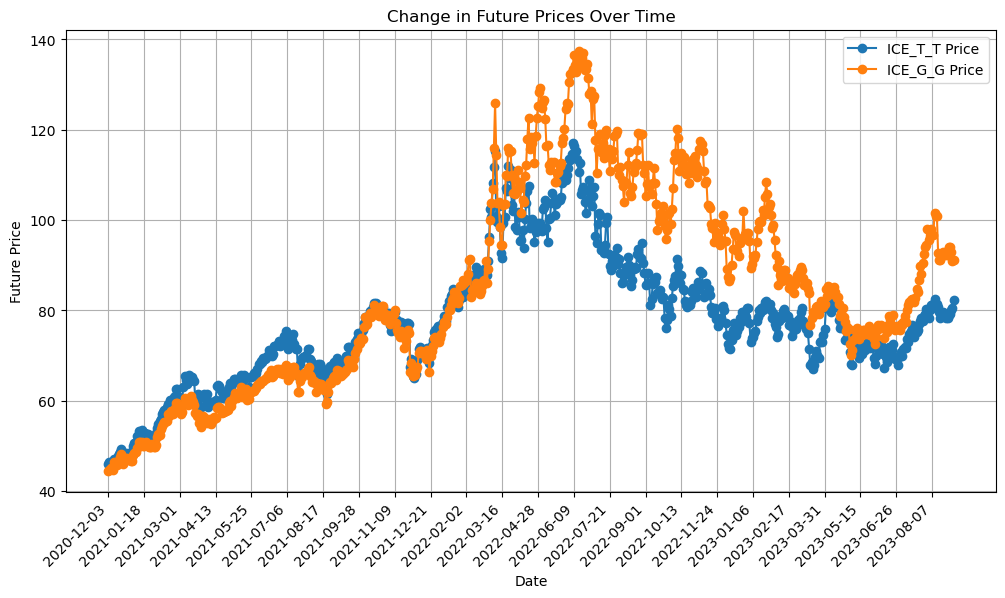

In [102]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(w_vs_x_spread['date'], w_vs_x_spread['ICE_T_T price'], label='ICE_T_T Price', marker='o')
plt.plot(w_vs_x_spread['date'], w_vs_x_spread['ICE_G_G price'], label='ICE_G_G Price', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Future Price')
plt.title('Change in Future Prices Over Time')

# Show legend
plt.legend()  

# Display every Nth date
N = 30
plt.xticks(w_vs_x_spread['date'][::N], rotation=45, ha='right')  

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, the prices for both futures tend to have a similar trend. They both start out low and peak around June 2022, after which they decline until July 2023, before rising again. </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the change in spread over time. </span>

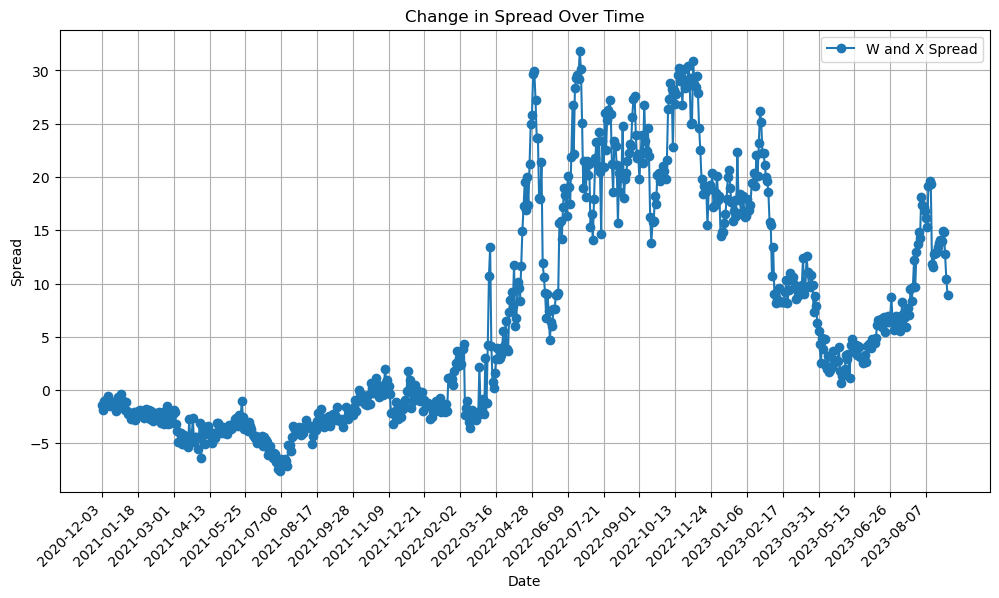

In [125]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(w_vs_x_spread['date'], w_vs_x_spread['spread'], label='W and X Spread', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Change in Spread Over Time')

# Show legend
plt.legend()  

# Display every Nth date
N = 30
plt.xticks(w_vs_x_spread['date'][::N], rotation=45, ha='right')  

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, the spread starts out low and peaks around June 2022, after which it declines until May 2023, before rising again. </span>

<span style="color: rgb(0, 0, 128);"> The code below computes the correlation between both futures and displays a scatterplot as well. </span>

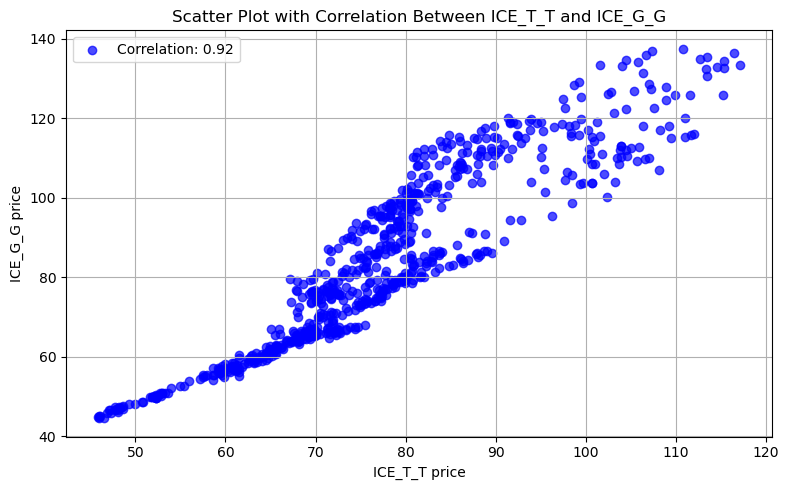

In [106]:
wxcorrelation = w_vs_x_spread['ICE_T_T price'].corr(w_vs_x_spread['ICE_G_G price'])

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(w_vs_x_spread['ICE_T_T price'], w_vs_x_spread['ICE_G_G price'], label=f'Correlation: {wxcorrelation:.2f}', color='blue', alpha=0.7)

# Adding labels and title
plt.xlabel('ICE_T_T price')
plt.ylabel('ICE_G_G price')
plt.title('Scatter Plot with Correlation Between ICE_T_T and ICE_G_G')

# Adding legend
plt.legend()

# Adding grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, there is a very strong positive correlation of 0.92 between prices of both futures. </span>

## 2.2 Futures Pair Y vs. Z

<span style="color: rgb(0, 0, 128);"> The code below computes descriptive statistics such as mean, median, standard deviation, sharpe ratio, skewness, and excess kurtosis, for both futures along with their spread. </span>

In [108]:
ymean = y_vs_z_spread['NYM_RB_RB price'].mean()
ymedian = y_vs_z_spread['NYM_RB_RB price'].median()
yvol = y_vs_z_spread['NYM_RB_RB price'].std()
ysharpe_ratio = ymean/yvol
yskewness = y_vs_z_spread['NYM_RB_RB price'].skew()
yexcess_kurtosis = y_vs_z_spread['NYM_RB_RB price'].kurtosis()

zmean = y_vs_z_spread['ICE_G_G price'].mean()
zmedian = y_vs_z_spread['ICE_G_G price'].median()
zvol = y_vs_z_spread['ICE_G_G price'].std()
zsharpe_ratio = zmean/zvol
zskewness = y_vs_z_spread['ICE_G_G price'].skew()
zexcess_kurtosis = y_vs_z_spread['ICE_G_G price'].kurtosis()

mean = y_vs_z_spread['spread'].mean()
median = y_vs_z_spread['spread'].median()
vol = y_vs_z_spread['spread'].std()
sharpe_ratio = mean/vol
skewness = y_vs_z_spread['spread'].skew()
excess_kurtosis = y_vs_z_spread['spread'].kurtosis()

titles = ['Future', 'Mean', 'Median', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Excess Kurtosis']
yvalues = ['NYM_RB_RB', ymean, ymedian, yvol, ysharpe_ratio, yskewness, yexcess_kurtosis]
zvalues = ['ICE_G_G', zmean, zmedian, zvol, zsharpe_ratio, zskewness, zexcess_kurtosis]
values = ['Spread', mean, median, vol, sharpe_ratio, skewness, excess_kurtosis]

# Create a dictionary with lists
yzdata_dict = {titles[i]: [yvalues[i], zvalues[i], values[i]] for i in range(len(titles))}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(yzdata_dict)

# Display the DataFrame
print(df)

      Future      Mean    Median  Volatility  Sharpe Ratio  Skewness  \
0  NYM_RB_RB  2.426165  2.381100    0.493998      4.911284  0.527942   
1    ICE_G_G  2.531639  2.436225    0.665509      3.804062  0.306619   
2     Spread  0.105474 -0.008650    0.342672      0.307798  1.009396   

   Excess Kurtosis  
0         0.588673  
1        -0.788673  
2        -0.055007  


<span style="color: rgb(255,69,0);"> The table above shows the descriptive statistics such as mean, median, standard deviation, sharpe ratio, skewness, and excess kurtosis, for both futures along with their spread. The future NYM_RB_RB has a slightly lower mean, median, and volatility than the future ICE_G_G. However, the future NYM_RB_RB has a slightly higher sharpe ratio. Additionally, the future NYM_RB_RB has a higher skewness (measures asymmetery) and excess kurtosis (measures tail-heaviness of a distribution's peak). The spread has a mean of 0.105, median of -0.009, standard deviation of 0.343, sharpe ratio of 0.308, skewness of 1.01 (moderate right skew), and excess kurtosis of -0.055 (negative; less pronounced; thinner tails than a normal distribution). </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the change in prices for both futures w and x. </span>

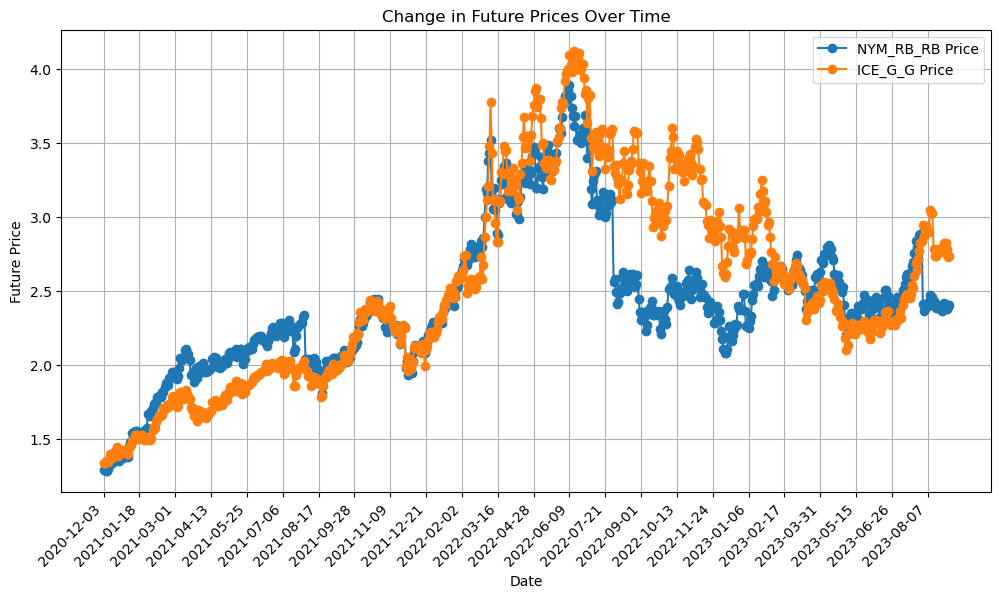

In [112]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_vs_z_spread['date'], y_vs_z_spread['NYM_RB_RB price'], label='NYM_RB_RB Price', marker='o')
plt.plot(y_vs_z_spread['date'], y_vs_z_spread['ICE_G_G price'], label='ICE_G_G Price', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Future Price')
plt.title('Change in Future Prices Over Time')

# Show legend
plt.legend()  

# Display every Nth date
N = 30
plt.xticks(y_vs_z_spread['date'][::N], rotation=45, ha='right')  

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, the prices for both futures tend to have a similar trend. They both start out low and peak around June 2022, after which they decline until July 2023, before rising again. </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the change in spread over time. </span>

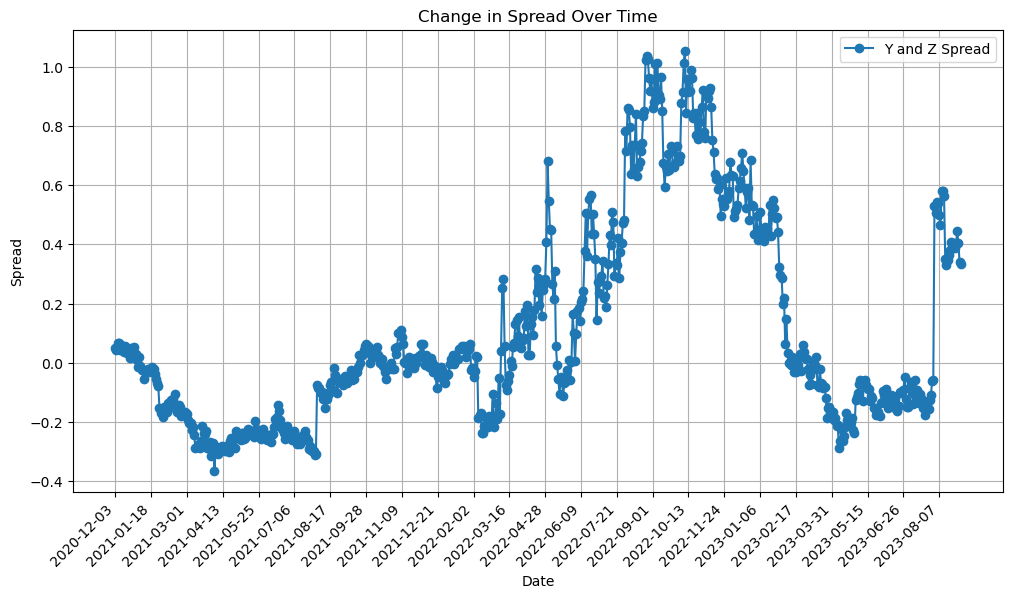

In [124]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_vs_z_spread['date'], y_vs_z_spread['spread'], label='Y and Z Spread', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Change in Spread Over Time')

# Show legend
plt.legend()  

# Display every Nth date
N = 30
plt.xticks(y_vs_z_spread['date'][::N], rotation=45, ha='right')  

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, the spread starts out low and peaks around October 2022, after which it declines until June 2023, before rising again. </span>

<span style="color: rgb(0, 0, 128);"> The code below computes the correlation between both futures and displays a scatterplot as well. </span>

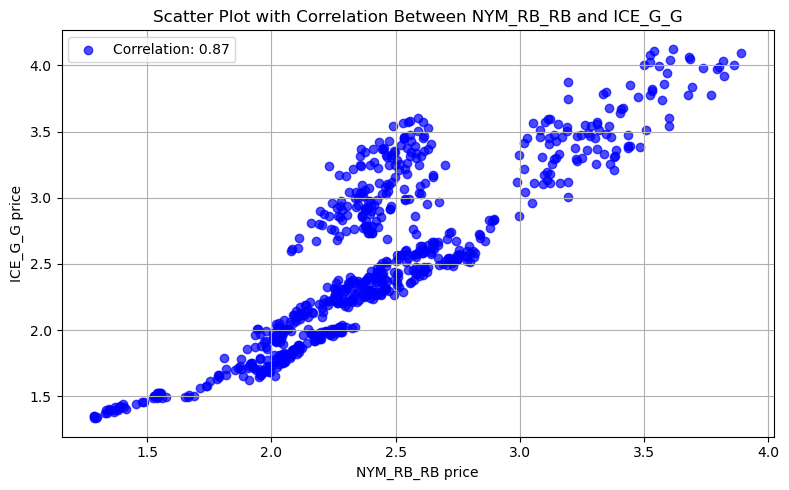

In [113]:
yzcorrelation = y_vs_z_spread['NYM_RB_RB price'].corr(y_vs_z_spread['ICE_G_G price'])

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(y_vs_z_spread['NYM_RB_RB price'], y_vs_z_spread['ICE_G_G price'], label=f'Correlation: {yzcorrelation:.2f}', color='blue', alpha=0.7)

# Adding labels and title
plt.xlabel('NYM_RB_RB price')
plt.ylabel('ICE_G_G price')
plt.title('Scatter Plot with Correlation Between NYM_RB_RB and ICE_G_G')

# Adding legend
plt.legend()

# Adding grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, there is a very strong positive correlation of 0.87 between prices of both futures. </span>

## 2.3 Futures Pairs W vs. X and Y vs. Z

<span style="color: rgb(0, 0, 128);"> The code below creates a new dataframe that merges spread data for both futures pairs along with creating a new column for difference. </span>

In [119]:
spreads = pd.merge(w_vs_x_spread[['date', 'spread']], y_vs_z_spread[['date', 'spread']], on='date', how='inner')

spreads = spreads.rename(columns={'spread_x':'ICE_T_T vs ICE G_G Spread'})
spreads = spreads.rename(columns={'spread_y':'NYM_RB_RB vs ICE G_G Spread'})

spreads['Spread Difference'] = spreads['NYM_RB_RB vs ICE G_G Spread'] - spreads['ICE_T_T vs ICE G_G Spread']

spreads

,date,ICE_T_T vs ICE G_G Spread,NYM_RB_RB vs ICE G_G Spread,Spread Difference
0,2020-12-03,-1.3875,0.048975,1.436475
1,2020-12-04,-1.8800,0.044700,1.924700
2,2020-12-07,-0.9900,0.068000,1.058000
3,2020-12-08,-0.8875,0.067075,0.954575
4,2020-12-09,-1.1275,0.043975,1.171475
...,...,...,...,...
704,2023-08-25,14.9600,0.399400,-14.560600
705,2023-08-28,14.8675,0.443625,-14.423875
706,2023-08-29,12.7250,0.405850,-12.319150
707,2023-08-30,10.4550,0.339250,-10.115750


<span style="color: rgb(0, 0, 128);"> The code below computes descriptive statistics such as mean, median, standard deviation, sharpe ratio, skewness, and excess kurtosis, for both futures pairs spreads along with the spread difference. </span>

In [120]:
amean = spreads['ICE_T_T vs ICE G_G Spread'].mean()
amedian = spreads['ICE_T_T vs ICE G_G Spread'].median()
avol = spreads['ICE_T_T vs ICE G_G Spread'].std()
asharpe_ratio = amean/avol
askewness = spreads['ICE_T_T vs ICE G_G Spread'].skew()
aexcess_kurtosis = spreads['ICE_T_T vs ICE G_G Spread'].kurtosis()

bmean = spreads['NYM_RB_RB vs ICE G_G Spread'].mean()
bmedian = spreads['NYM_RB_RB vs ICE G_G Spread'].median()
bvol = spreads['NYM_RB_RB vs ICE G_G Spread'].std()
bsharpe_ratio = bmean/bvol
bskewness = spreads['NYM_RB_RB vs ICE G_G Spread'].skew()
bexcess_kurtosis = spreads['NYM_RB_RB vs ICE G_G Spread'].kurtosis()

mean = spreads['Spread Difference'].mean()
median = spreads['Spread Difference'].median()
vol = spreads['Spread Difference'].std()
sharpe_ratio = mean/vol
skewness = spreads['Spread Difference'].skew()
excess_kurtosis = spreads['Spread Difference'].kurtosis()

titles = ['Spread', 'Mean', 'Median', 'Volatility', 'Sharpe Ratio', 'Skewness', 'Excess Kurtosis']
avalues = ['ICE_T_T vs ICE G_G Spread', amean, amedian, avol, asharpe_ratio, askewness, aexcess_kurtosis]
bvalues = ['NYM_RB_RB vs ICE G_G Spread', bmean, bmedian, bvol, bsharpe_ratio, bskewness, bexcess_kurtosis]
values = ['Spread Difference', mean, median, vol, sharpe_ratio, skewness, excess_kurtosis]

# Create a dictionary with lists
abdata_dict = {titles[i]: [avalues[i], bvalues[i], values[i]] for i in range(len(titles))}

# Convert the dictionary to a DataFrame
df = pd.DataFrame(abdata_dict)

# Display the DataFrame
print(df)

                        Spread      Mean    Median  Volatility  Sharpe Ratio  \
0    ICE_T_T vs ICE G_G Spread  6.853713  3.632500   10.507720      0.652255   
1  NYM_RB_RB vs ICE G_G Spread  0.105474 -0.008650    0.342672      0.307798   
2            Spread Difference -6.748239 -3.583725   10.207308     -0.661118   

   Skewness  Excess Kurtosis  
0  0.623975        -0.931265  
1  1.009396        -0.055007  
2 -0.613317        -0.941552  


<span style="color: rgb(255,69,0);"> The table above shows the descriptive statistics such as mean, median, standard deviation, sharpe ratio, skewness, and excess kurtosis, for both futures spreads along with the difference between both spreads. The ICE_T_T vs ICE_G_G spread has a higher mean, median, volatility, and sharpe ratio than the NYM_RB_RB vs ICE_G_G spread. Additionally, the ICE_T_T vs ICE_G_G spread has a lower skewness (measures asymmetery) and excess kurtosis (measures tail-heaviness of a distribution's peak). The spread difference has a mean of -6.75, median of -3.58, standard deviation of 10.21, sharpe ratio of -0.66, skewness of -0.61 (moderate left skew), and excess kurtosis of -0.94 (negative; very pronounced; thinner tails than a normal distribution). </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the change in both spreads over time. </span>

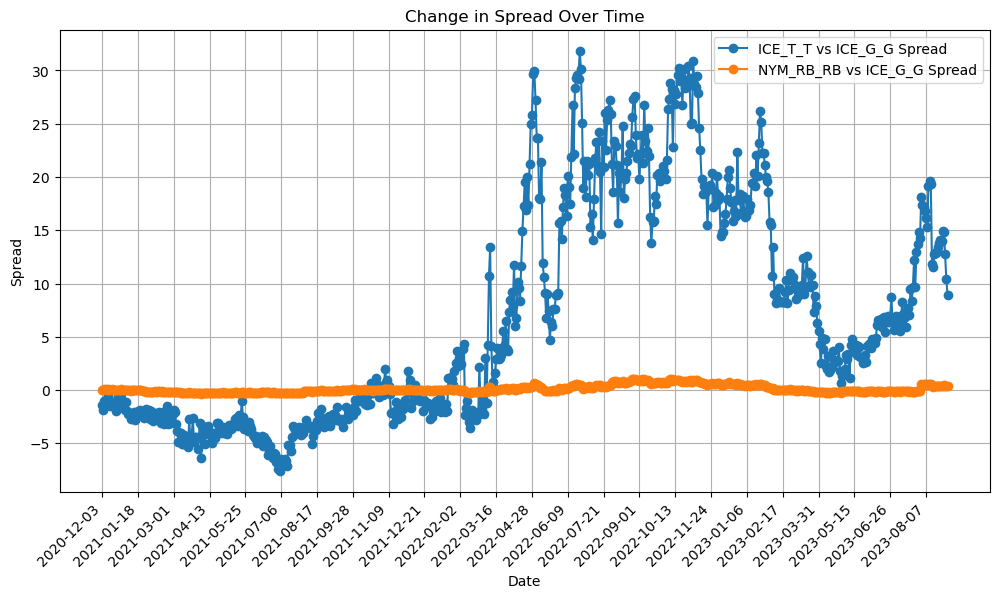

In [123]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(spreads['date'], spreads['ICE_T_T vs ICE G_G Spread'], label='ICE_T_T vs ICE_G_G Spread', marker='o')
plt.plot(spreads['date'], spreads['NYM_RB_RB vs ICE G_G Spread'], label='NYM_RB_RB vs ICE_G_G Spread', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('Change in Spread Over Time')

# Show legend
plt.legend()  

# Display every Nth date
N = 30
plt.xticks(spreads['date'][::N], rotation=45, ha='right')  

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, spread for ICE_T_T vs. ICE_G_G starts out low and peaks around June 2022, after which it declines until July 2023, before rising again. The spread for NYM_RB_RB vs. ICE_G_G, on the other hand, remains flat (~0) for the most part - But if you scale it you will see similar peaks / downfalls as the first spread. </span>

<span style="color: rgb(0, 0, 128);"> The code below plots the change in spread difference over time. </span>

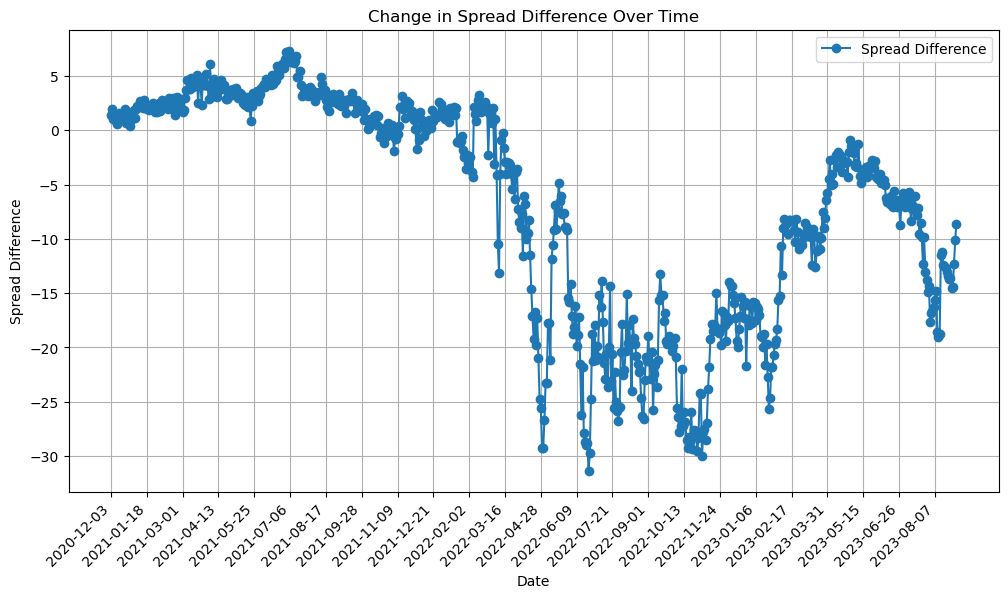

In [126]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(spreads['date'], spreads['Spread Difference'], label='Spread Difference', marker='o')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Spread Difference')
plt.title('Change in Spread Difference Over Time')

# Show legend
plt.legend()  

# Display every Nth date
N = 30
plt.xticks(spreads['date'][::N], rotation=45, ha='right')  

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, the spread difference starts closer to 0 and drops around June 2022, after which it lessens until March 2023, before increasing again. </span>

<span style="color: rgb(0, 0, 128);"> The code below computes the correlation between both future pairs spreads and displays a scatterplot as well. </span>

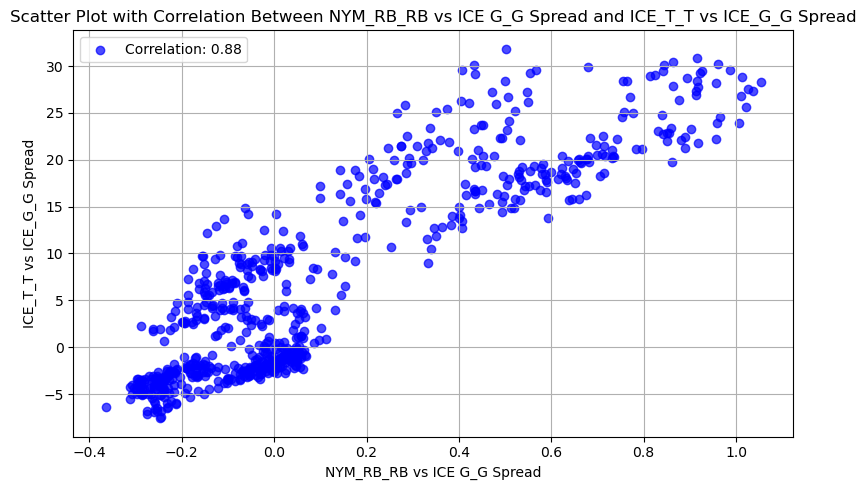

In [128]:
correlation = spreads['NYM_RB_RB vs ICE G_G Spread'].corr(spreads['ICE_T_T vs ICE G_G Spread'])

# Plotting
plt.figure(figsize=(8, 5))
plt.scatter(spreads['NYM_RB_RB vs ICE G_G Spread'], spreads['ICE_T_T vs ICE G_G Spread'], label=f'Correlation: {correlation:.2f}', color='blue', alpha=0.7)

# Adding labels and title
plt.xlabel('NYM_RB_RB vs ICE G_G Spread')
plt.ylabel('ICE_T_T vs ICE_G_G Spread')
plt.title('Scatter Plot with Correlation Between NYM_RB_RB vs ICE G_G Spread and ICE_T_T vs ICE_G_G Spread')

# Adding legend
plt.legend()

# Adding grid lines
plt.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, there is a very strong positive correlation of 0.88 between prices of both futures. </span>

<span style="color: rgb(0, 0, 128);"> The code below produces and comments on the left and right tails for both spreads. </span>

In [140]:
left_tail = spreads['ICE_T_T vs ICE G_G Spread'].sort_values().head()
left_tail

149   -7.5725
147   -7.4225
155   -7.1225
148   -6.8750
152   -6.8525
Name: ICE_T_T vs ICE G_G Spread, dtype: float64

In [141]:
right_tail = spreads['ICE_T_T vs ICE G_G Spread'].sort_values().tail()
right_tail

401    30.1625
483    30.1850
491    30.4050
495    30.9050
400    31.8500
Name: ICE_T_T vs ICE G_G Spread, dtype: float64

<span style="color: rgb(255,69,0);"> As shown above, we can see the most positive and negative extreme values for the ICE-T_T vs ICE_G_G spread. The positive tail has significantly higher values than the negative tail. </span>

In [142]:
left_tail = spreads['NYM_RB_RB vs ICE G_G Spread'].sort_values().head()
left_tail

83    -0.364150
80    -0.312975
167   -0.311275
86    -0.307900
168   -0.307675
Name: NYM_RB_RB vs ICE G_G Spread, dtype: float64

In [144]:
right_tail = spreads['NYM_RB_RB vs ICE G_G Spread'].sort_values().tail()
right_tail

476    1.013425
444    1.022250
446    1.025600
445    1.036175
477    1.053300
Name: NYM_RB_RB vs ICE G_G Spread, dtype: float64

<span style="color: rgb(255,69,0);"> As shown above, we can see the most positive and negative extreme values for the NYM_RB_RB vs ICE_G_G spread. The positive tail has significantly higher values than the negative tail. </span>

<span style="color: rgb(0, 0, 128);"> The code below fits a regression to predict the second spread (Y vs Z) using the first spread (W vs X), displays important statistics, and also plots the results. </span>

                                     OLS Regression Results                                     
Dep. Variable:     NYM_RB_RB vs ICE G_G Spread   R-squared (uncentered):                   0.749
Model:                                     OLS   Adj. R-squared (uncentered):              0.749
Method:                          Least Squares   F-statistic:                              2114.
Date:                         Mon, 22 Jan 2024   Prob (F-statistic):                   8.83e-215
Time:                                 22:45:31   Log-Likelihood:                          211.87
No. Observations:                          709   AIC:                                     -421.7
Df Residuals:                              708   BIC:                                     -417.2
Df Model:                                    1                                                  
Covariance Type:                     nonrobust                                                  
                              

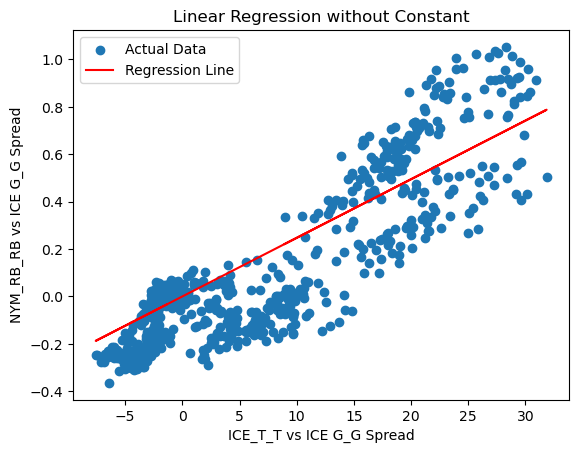

In [152]:
# Fit the regression model without a constant
model = sm.OLS(spreads['NYM_RB_RB vs ICE G_G Spread'], spreads['ICE_T_T vs ICE G_G Spread']).fit()

# Display regression results
print(model.summary())

# Predict values using the model
predictions = model.predict(spreads['ICE_T_T vs ICE G_G Spread'])

# Plot the regression line
plt.scatter(spreads['ICE_T_T vs ICE G_G Spread'], spreads['NYM_RB_RB vs ICE G_G Spread'], label='Actual Data')
plt.plot(spreads['ICE_T_T vs ICE G_G Spread'], predictions, label='Regression Line', color='red')
plt.xlabel('ICE_T_T vs ICE G_G Spread')
plt.ylabel('NYM_RB_RB vs ICE G_G Spread')
plt.title('Linear Regression without Constant')
plt.legend()
plt.show()

<span style="color: rgb(255,69,0);"> The results above show that there is a strong relationship between both spreads as denoted by the regression summary. Particularly, the R^Squared value is 0.749 (which means that around 75% of the variation in the dependent variable can be explained by changes in the independent variable) and F-Statistic probability is significant. </span>

<span style="color: rgb(0, 0, 128);"> The code below computes 3 N-day rolling averages for both spreads and the spread difference along with plotting the results respectively. </span>

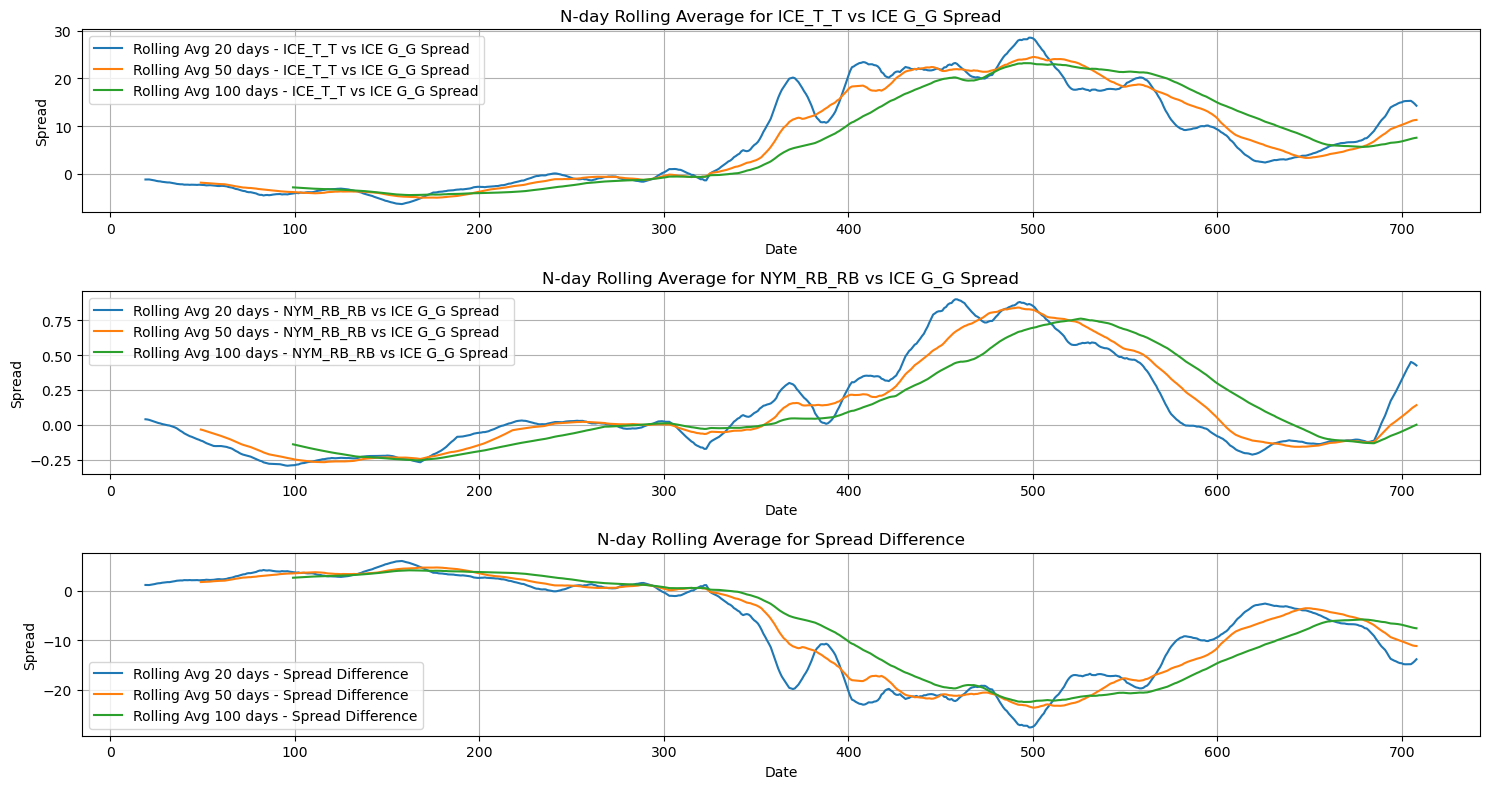

In [151]:
# Specify the N values for the rolling average
n_values = [20, 50, 100]

# Create separate plots for each spread
plt.figure(figsize=(15, 8))

# Plotting for ICE_T_T vs ICE G_G Spread
plt.subplot(3, 1, 1)
for n in n_values:
    spreads[f'Rolling_Avg_{n}_days_w_vs_x'] = spreads['ICE_T_T vs ICE G_G Spread'].rolling(window=n).mean()
    plt.plot(spreads.index, spreads[f'Rolling_Avg_{n}_days_w_vs_x'], label=f'Rolling Avg {n} days - ICE_T_T vs ICE G_G Spread')

# Adding labels and title for the first plot
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('N-day Rolling Average for ICE_T_T vs ICE G_G Spread')
plt.legend()
plt.grid(True)

# Plotting for NYM_RB_RB vs ICE G_G Spread
plt.subplot(3, 1, 2)
for n in n_values:
    spreads[f'Rolling_Avg_{n}_days_y_vs_z'] = spreads['NYM_RB_RB vs ICE G_G Spread'].rolling(window=n).mean()
    plt.plot(spreads.index, spreads[f'Rolling_Avg_{n}_days_y_vs_z'], label=f'Rolling Avg {n} days - NYM_RB_RB vs ICE G_G Spread')

# Adding labels and title for the second plot
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('N-day Rolling Average for NYM_RB_RB vs ICE G_G Spread')
plt.legend()
plt.grid(True)

# Plotting for Spread Difference
plt.subplot(3, 1, 3)
for n in n_values:
    spreads[f'Rolling_Avg_{n}_days'] = spreads['Spread Difference'].rolling(window=n).mean()
    plt.plot(spreads.index, spreads[f'Rolling_Avg_{n}_days'], label=f'Rolling Avg {n} days - Spread Difference')

# Adding labels and title for the second plot
plt.xlabel('Date')
plt.ylabel('Spread')
plt.title('N-day Rolling Average for Spread Difference')
plt.legend()
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

<span style="color: rgb(255,69,0);"> As shown above, both N-day rolling average plots for the spreads have similar trends where the moving averages tend to peak towards the middle of 2022. Similarly, the N-day rolling average plot for the spread difference drops to a low around the same time both other spread graphs peak. </span>

### Context
<span style="color: rgb(255,69,0);"> All the analysis done in this homework assignment needs to be put into context of global events to better understand the trends shown. Around mid-2022, when most futures prices / spreads peaked, the US Federal Reserve continued interest rate hikes, inflation accross the globe soared, and Russia's war on Ukraine continued. These are some of the reasons that could explain the trends shown in this assignment. </span>

### Summary
<span style="color: rgb(255,69,0);"> In summary, this data science assignment involved the collection and cleaning of futures pairs data, which were used to determine 2 separate sets of spreads. Both futures pairs, both spreads, and the difference between both spreads were separately analyzed using a variety of descriptive statistics, time-series plots, scatterplots, and moving average analysis. </span>